In [538]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import requests
import scipy.stats as sps
import arviz as az

sns.set()

In [539]:
start_date = '2020-03-01'
end_date = '2020-08-14'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

r = requests.get(url,timeout=5.0)
r.status_code

200

In [540]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14'],
              dtype='datetime64[ns]', length=167, freq='D')

In [541]:
json = r.json()
data = json['data']
countries = json['countries']

In [542]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            pass

In [543]:
df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
df['date'] = pd.to_datetime(df['date'])
df.set_index(['country','date'],inplace=True)
df.loc['GBR']

,confirmed,dead,oxford_stringency
date,,,
2020-03-01,42.0,0.0,11.11
2020-03-02,47.0,0.0,11.11
2020-03-03,69.0,0.0,11.11
2020-03-04,109.0,0.0,11.11
2020-03-05,164.0,0.0,11.11
...,...,...,...
2020-08-02,303952.0,46193.0,68.06
2020-08-03,304695.0,46201.0,68.06
2020-08-04,305623.0,46210.0,65.28


In [544]:
average_ox_idx = df['oxford_stringency'].groupby(level=0).mean()
average_ox_idx

country
ABW    47.951761
AFG    72.957244
AGO    68.882956
AIA    50.593821
ALB    71.375912
         ...    
VUT    59.987848
YEM    42.719182
ZAF    73.847296
ZMB    44.964241
ZWE    70.951447
Name: oxford_stringency, Length: 183, dtype: float64

In [545]:
population = pd.read_csv('world_pop.csv',sep=';',thousands=',',header=None,index_col=0)
population.columns=['pop']
population.index.name='country'
population

,pop
country,
Afghanistan,38928346
Albania,2877797
Algeria,43851044
American Samoa,55191
Andorra,77265
...,...
Wallis & Futuna,11239
Western Sahara,597339
Yemen,29825964


In [546]:
three_letter_abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=2)
three_letter_abb = three_letter_abb[0]
three_letter_abb.loc['GBR']

'UK'

In [547]:
df = df.reset_index(level=1)

In [548]:
df.loc['GBR']

,date,confirmed,dead,oxford_stringency
country,,,,
GBR,2020-03-01,42.0,0.0,11.11
GBR,2020-03-02,47.0,0.0,11.11
GBR,2020-03-03,69.0,0.0,11.11
GBR,2020-03-04,109.0,0.0,11.11
GBR,2020-03-05,164.0,0.0,11.11
...,...,...,...,...
GBR,2020-08-02,303952.0,46193.0,68.06
GBR,2020-08-03,304695.0,46201.0,68.06
GBR,2020-08-04,305623.0,46210.0,65.28


In [549]:
df = df.join(three_letter_abb)

In [550]:
df.rename(columns={0 : 'country'},inplace=True)

In [551]:
df = df.join(average_ox_idx,lsuffix='_current',rsuffix='_mean')

In [552]:
df

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean
ABW,2020-03-01,NaN,NaN,0.00,Aruba,47.951761
ABW,2020-03-02,NaN,NaN,0.00,Aruba,47.951761
ABW,2020-03-03,NaN,NaN,0.00,Aruba,47.951761
ABW,2020-03-04,NaN,NaN,0.00,Aruba,47.951761
ABW,2020-03-05,NaN,NaN,0.00,Aruba,47.951761
...,...,...,...,...,...,...
ZWE,2020-08-02,3659.0,69.0,80.56,Zimbabwe,70.951447
ZWE,2020-08-03,3921.0,70.0,80.56,Zimbabwe,70.951447
ZWE,2020-08-04,4075.0,80.0,80.56,Zimbabwe,70.951447
ZWE,2020-08-05,4221.0,81.0,80.56,Zimbabwe,70.951447


In [553]:
foo = df.merge(population,left_on='country',right_on=population.index)
foo['dead_per_M'] = foo['dead'] / (foo['pop'] / 1e6)
foo

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M
0,2020-03-01,NaN,NaN,0.00,Aruba,47.951761,106766,NaN
1,2020-03-02,NaN,NaN,0.00,Aruba,47.951761,106766,NaN
2,2020-03-03,NaN,NaN,0.00,Aruba,47.951761,106766,NaN
3,2020-03-04,NaN,NaN,0.00,Aruba,47.951761,106766,NaN
4,2020-03-05,NaN,NaN,0.00,Aruba,47.951761,106766,NaN
...,...,...,...,...,...,...,...,...
26716,2020-08-02,3659.0,69.0,80.56,Zimbabwe,70.951447,14862924,4.642424
26717,2020-08-03,3921.0,70.0,80.56,Zimbabwe,70.951447,14862924,4.709706
26718,2020-08-04,4075.0,80.0,80.56,Zimbabwe,70.951447,14862924,5.382521
26719,2020-08-05,4221.0,81.0,80.56,Zimbabwe,70.951447,14862924,5.449802


In [554]:
three_letter_abb.name='country'
three_letter_abb.index.name='abb'
three_letter_abb = pd.DataFrame(three_letter_abb)
three_letter_abb.columns=['country']
three_letter_abb.reset_index(inplace=True)


In [555]:
three_letter_abb

,abb,country
0,AFG,Afghanistan
1,ALB,Albania
2,DZA,Algeria
3,ASM,American Samoa
4,AND,Andorra
...,...,...
256,ESH,Western Sahara
257,YEM,Yemen
258,ZMB,Zambia
259,ZWE,Zimbabwe


In [556]:
foo = foo.merge(three_letter_abb,left_on='country',right_on='country')
foo

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb
0,2020-03-01,NaN,NaN,0.00,Aruba,47.951761,106766,NaN,ABW
1,2020-03-02,NaN,NaN,0.00,Aruba,47.951761,106766,NaN,ABW
2,2020-03-03,NaN,NaN,0.00,Aruba,47.951761,106766,NaN,ABW
3,2020-03-04,NaN,NaN,0.00,Aruba,47.951761,106766,NaN,ABW
4,2020-03-05,NaN,NaN,0.00,Aruba,47.951761,106766,NaN,ABW
...,...,...,...,...,...,...,...,...,...
26716,2020-08-02,3659.0,69.0,80.56,Zimbabwe,70.951447,14862924,4.642424,ZWE
26717,2020-08-03,3921.0,70.0,80.56,Zimbabwe,70.951447,14862924,4.709706,ZWE
26718,2020-08-04,4075.0,80.0,80.56,Zimbabwe,70.951447,14862924,5.382521,ZWE
26719,2020-08-05,4221.0,81.0,80.56,Zimbabwe,70.951447,14862924,5.449802,ZWE


In [557]:
gbr = foo.loc[foo['abb'] == 'GBR']
gbr

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb
9009,2020-03-01,42.0,0.0,11.11,UK,63.243333,67886011,0.000000,GBR
9010,2020-03-02,47.0,0.0,11.11,UK,63.243333,67886011,0.000000,GBR
9011,2020-03-03,69.0,0.0,11.11,UK,63.243333,67886011,0.000000,GBR
9012,2020-03-04,109.0,0.0,11.11,UK,63.243333,67886011,0.000000,GBR
9013,2020-03-05,164.0,0.0,11.11,UK,63.243333,67886011,0.000000,GBR
...,...,...,...,...,...,...,...,...,...
9163,2020-08-02,303952.0,46193.0,68.06,UK,63.243333,67886011,680.449467,GBR
9164,2020-08-03,304695.0,46201.0,68.06,UK,63.243333,67886011,680.567312,GBR
9165,2020-08-04,305623.0,46210.0,65.28,UK,63.243333,67886011,680.699887,GBR
9166,2020-08-05,306293.0,46299.0,65.28,UK,63.243333,67886011,682.010908,GBR


In [558]:
last_data_date = gbr['date'].iloc[-1]
last_data_date

Timestamp('2020-08-06 00:00:00')

In [559]:
last_days = foo.loc[foo['date'] == last_data_date]
drop = ['San Marino','Andorra']

mask = last_days['country'].isin(drop)
last_days = last_days[~mask]

#last_days = last_days.merge(three_letter_abb,left_on='country',right_on='country')

last_days['conf_per_M'] = last_days['confirmed'] / (last_days['pop'] / 1e6)

### MASK ###
mask2 = last_days['dead_per_M'] > 10
############

last_days = last_days[mask2]
last_days['dead_per_M_log'] = np.log10(last_days['dead_per_M'])

last_days

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,conf_per_M,dead_per_M_log
158,2020-08-06,171.0,3.0,43.52,Aruba,47.951761,106766,28.098833,ABW,1601.633479,1.448688
755,2020-08-06,5889.0,182.0,59.26,Albania,71.375912,2877797,63.242821,ALB,2046.356988,1.801011
1071,2020-08-06,61860.0,355.0,50.00,United Arab Emirates,65.088987,9890402,35.893384,ARE,6254.548602,1.555014
1230,2020-08-06,213522.0,4009.0,88.89,Argentina,84.294025,45195774,88.702984,ARG,4724.379762,1.947938
1548,2020-08-06,21575.0,719.0,31.48,Austria,53.416524,9006398,79.832137,AUT,2395.519274,1.902178
...,...,...,...,...,...,...,...,...,...,...,...
25450,2020-08-06,75490.0,1788.0,54.17,Ukraine,66.219811,43733762,40.883746,UKR,1726.126373,1.611551
25609,2020-08-06,1309.0,37.0,22.22,Uruguay,47.879874,3473730,10.651375,URY,376.828366,1.027406
25768,2020-08-06,4823891.0,158256.0,68.98,US,66.205660,331002651,478.110974,USA,14573.572101,2.679529
26244,2020-08-06,1764.0,508.0,31.48,Yemen,42.719182,29825964,17.032140,YEM,59.143101,1.231269


In [560]:
last_days.sort_values('oxford_stringency_mean',ascending=True).head(50)



,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,conf_per_M,dead_per_M_log
17997,2020-08-06,3902.0,123.0,16.67,Nicaragua,11.931761,6624554,18.567288,NIC,589.020785,1.268748
3142,2020-08-06,68376.0,577.0,11.11,Belarus,11.966541,9449323,61.062576,BLR,7236.073949,1.785775
23236,2020-08-06,81540.0,5760.0,37.04,Sweden,38.075786,10099265,570.338535,SWE,8073.854880,2.756133
12448,2020-08-06,1926.0,10.0,39.81,Iceland,40.384025,341243,29.304630,ISL,5644.071820,1.466936
26244,2020-08-06,1764.0,508.0,31.48,Yemen,42.719182,29825964,17.032140,YEM,59.143101,1.231269
8531,2020-08-06,7512.0,331.0,37.96,Finland,44.795157,5540720,59.739528,FIN,1355.780476,1.776262
15143,2020-08-06,7007.0,118.0,22.22,Luxembourg,47.488805,625978,188.505027,LUX,11193.684123,2.275323
25609,2020-08-06,1309.0,37.0,22.22,Uruguay,47.879874,3473730,10.651375,URY,376.828366,1.027406
158,2020-08-06,171.0,3.0,43.52,Aruba,47.951761,106766,28.098833,ABW,1601.633479,1.448688
18315,2020-08-06,9362.0,256.0,34.26,Norway,49.550943,5421241,47.221660,NOR,1726.910868,1.674141


In [561]:
last_days.shape

(87, 11)

In [562]:
x = last_days['oxford_stringency_mean']

y_param = 'dead_per_M'

if y_param == 'dead_per_M':
    beta_mean = 0
    beta_std = 2
    alpha_low = -500
    alpha_high = 500
    obs_sigma_high = 500
    
else:
    beta_mean = 0
    beta_std = 1000
    alpha_low = -4000
    alpha_high = 4000
    obs_sigma_high = 10000
    
model = pm.Model()

with model:

    alpha = pm.Uniform('alpha',alpha_low,alpha_high)
    #beta = pm.Uniform('beta',beta_low,beta_high)
    beta = pm.Normal('beta',mu=beta_mean, sd=beta_std )
    obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)


    linreq = alpha + x.values * beta

    obs = pm.Normal('obs',mu = linreq,sd=obs_sigma,observed = last_days[y_param])

    
    trace = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8857816790856721, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta         0.82   1.15   -1.33     3.04       0.04     0.03    724.25   
alpha       87.85  76.78  -59.65   232.30       2.85     2.32    726.30   
obs_sigma  178.64  13.75  153.90   204.04       0.47     0.34    855.88   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       724.25    726.58    655.92    1.0  
alpha      546.10    728.90    621.90    1.0  
obs_sigma  841.54    885.40    754.04    1.0  


,beta_post,alpha_post,obs_sigma_post
count,2000.000000,2000.000000,2000.000000
mean,0.817300,87.852137,178.640979
std,1.149205,76.780440,13.745524
min,-3.198009,-152.094460,142.489614
25%,0.073564,36.784089,168.592375
50%,0.816639,90.162860,177.565860
75%,1.579009,138.488142,187.510116
max,4.935616,355.588186,225.709150


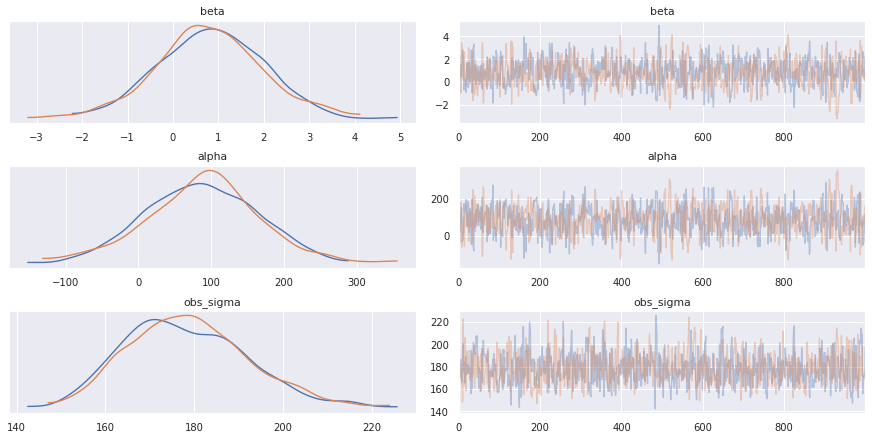

In [563]:
beta_post = trace['beta'][:]
alpha_post = trace['alpha'][:]
obs_sigma_post = trace['obs_sigma'][:]

_= az.plot_trace(trace)
print (az.summary(trace,round_to=2))

result = pd.DataFrame({'beta_post' : beta_post,
                      'alpha_post' : alpha_post,
                      'obs_sigma_post' : obs_sigma_post})

result.describe()

In [564]:
beta_ci = np.percentile(result['beta_post'],[5.5,94.5])
alpha_ci = np.percentile(result['alpha_post'],[5.5,94.5])

In [565]:
mean_req = np.array([x * result['beta_post'].mean() + result['alpha_post'].mean() for x in range(0,101)])

slope,intercept,_,_,_ = sps.linregress(last_days['oxford_stringency_mean'],last_days[y_param])

least_squares = np.array([x * slope + intercept for x in range(0,101)])

In [566]:
X = np.linspace(0,100,1000)
rows = np.random.choice(result.index,replace=True,size=len(X))
beta_samples = result['beta_post'][rows]
alpha_samples = result['alpha_post'][rows]

lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])


samples = np.array([pm.Normal.dist(X[i] * result.beta_post[rows] + result.alpha_post[rows],
                                      result.obs_sigma_post[rows]).random(size=len(X)) for i in range(len(X))])

high,low = np.percentile(samples,[5.5,94.5],axis=1)




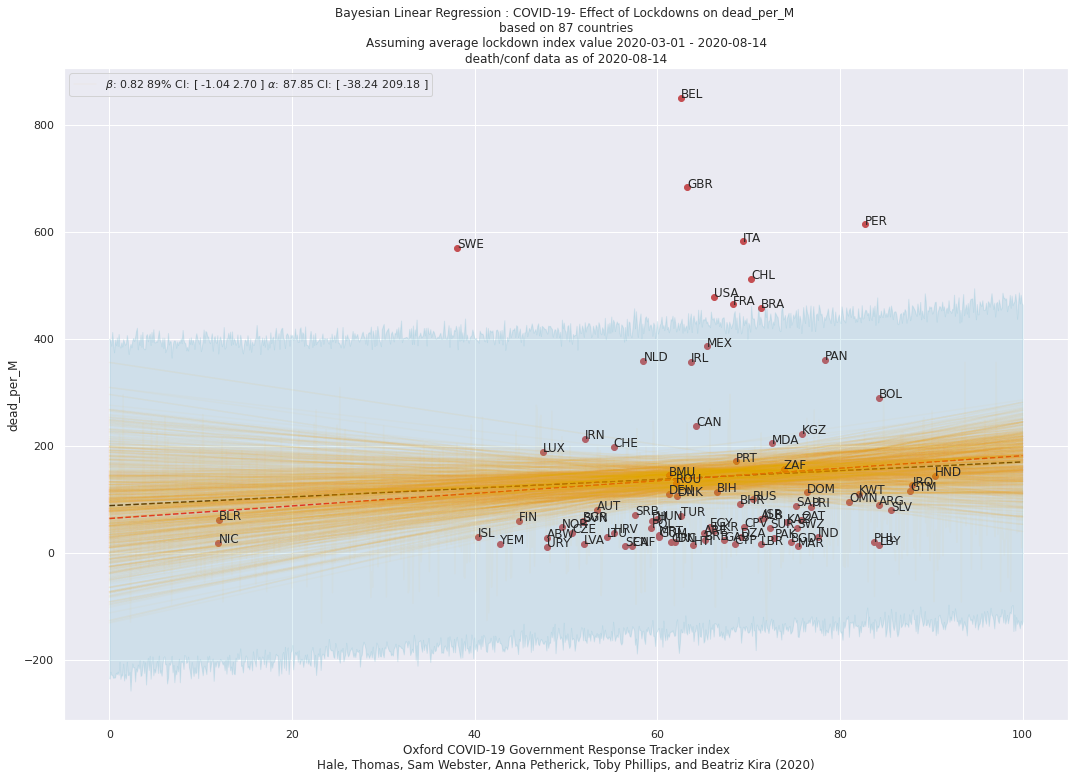

In [567]:
plt.figure(figsize=(18,12))
plt.title('Bayesian Linear Regression : COVID-19'\
          '- Effect of Lockdowns on {} \n'.format(y_param)+\
          'based on {} countries\n'.format(len(last_days))+\
          'Assuming average lockdown index value {} - {}\n'.format(start_date,end_date)+\
         'death/conf data as of {}'.format(end_date))

plt.scatter(last_days['oxford_stringency_mean'],last_days[y_param],color='r')
plt.ylabel(y_param)
plt.xlabel('Oxford COVID-19 Government Response Tracker index\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020)')

plt.plot(range(0,101),mean_req,ls='dashed',color='k')
plt.plot(range(0,101),least_squares,ls='dashed',color='crimson')

plt.fill_between(X,high,low,color='c',alpha=0.2)

countries_of_interest = ['SWE','GBR','BEL','ESP','ITA','PER','FRA',
                         'USA','DNK','FIN','NOR','BRA','CHL','QAT','BHR',
                        'HNT','GTM','NIC','JPN','ISL','ARG','NLD','DEU','ZAF','HND','IRQ']

for i,p in enumerate(last_days['oxford_stringency_mean']):
    #if last_days.iloc[i]['abb'] in countries_of_interest:
    plt.text(last_days.iloc[i]['oxford_stringency_mean'],last_days.iloc[i][y_param],last_days.iloc[i]['abb'])

plt.plot(X,lines[0,:],
         color='orange',
         alpha=0.03,
         label=r'$\beta$: {:.2f} 89% CI: [ {:.2f} {:.2f} ] $\alpha$: {:.2f} CI: [ {:.2f} {:.2f} ]'.format(
         result.beta_post.mean(),beta_ci[0],beta_ci[1],result.alpha_post.mean(),alpha_ci[0],alpha_ci[1]))

_=plt.plot(X,lines,color='orange',alpha=0.03)

plt.legend(loc='upper left')

plt.savefig('lockdown_index_{}.jpg'.format(y_param),format='jpg',dpi=400)

In [568]:
foo.dropna(inplace=True)

In [569]:
countries = foo.groupby('country')
some_countries = ['Sweden','Belgium','UK','South Africa','Germany','US',
                  'Denmark','Australia','Italy','France','Argentina','Brazil','Chile','Peru']

colors = ['black','grey','lightcoral','mistyrose','tan','gold','crimson','yellow',
         'deepskyblue','royalblue','orangered','lime','aqua','darkmagenta']



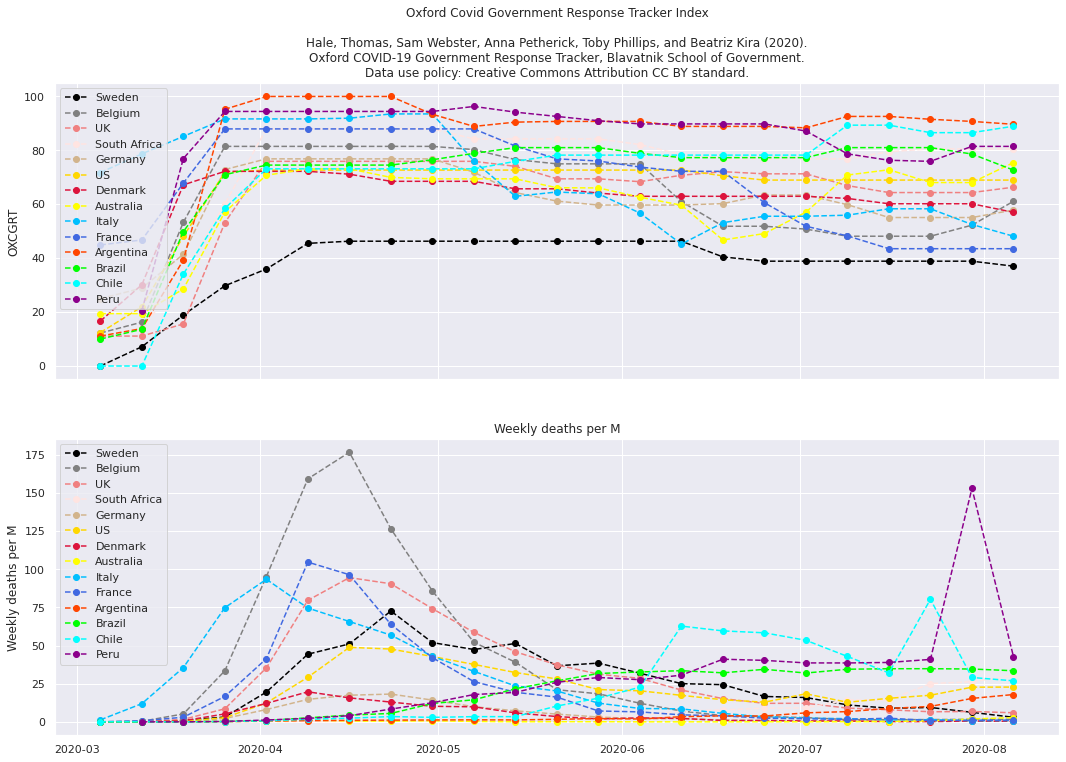

In [570]:
from datetime import datetime

weeklies = dict()

fig,ax = plt.subplots(2,1,sharex=True,figsize=(18,12))


for i,c in enumerate(some_countries):
    country = (countries.get_group(c)).copy()
    country.set_index('date',inplace=True)
    country['dead_inc'] = country['dead'] - country['dead'].shift()
    country['dead_inc_per_M'] = country['dead_inc'] / (country['pop'] / 1e6)
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    #today = datetime.today().weekday()
    last_data_day = last_data_date.weekday()

    #yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    period = resample_period[last_data_day]
    
    weekly = country.resample(period).agg({'dead_inc_per_M' : np.sum, 'dead_per_M' :np.sum,
                                           'oxford_stringency_current' : np.mean})
    
    weeklies[c] = weekly
        
    ax[1].plot(weekly.index,weekly['dead_inc_per_M'],'o--',label=c,color=colors[i])
    ax[0].plot(weekly.index,weekly['oxford_stringency_current'],'o--',label=c,color=colors[i])
 
citation = '\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020).\nOxford COVID-19 Government Response Tracker, Blavatnik School of Government.\nData use policy: Creative Commons Attribution CC BY standard.'
ax[0].legend(loc='upper left')
ax[0].set_title('Oxford Covid Government Response Tracker Index\n' + citation)
ax[0].set_ylabel('OXCGRT')
#ax[0].set_yscale('log')
ax[1].legend(loc='upper left')
ax[1].set_title('Weekly deaths per M')
ax[1].set_ylabel('Weekly deaths per M')
#ax[1].set_yscale('log')
plt.savefig('oxcgrt_country_plot.jpg',format='jpg',dpi=400)

In [571]:

def inference(x,y):
    
    beta_mean = 0
    beta_std = 10
    alpha_low = -500
    alpha_high = 500
    obs_sigma_high = 1000
    
    model = pm.Model()
    
    with model:

        alpha = pm.Uniform('alpha',alpha_low,alpha_high)
        beta = pm.Normal('beta',mu=beta_mean,sd=beta_std)
        obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

        linreq = alpha + x.values * beta

        obs = pm.Normal('obs',mu = linreq,tau = 1 / obs_sigma ** 2,observed = y)

        trace = pm.sample(1000,tune=1000)   

        beta_post = trace['beta'][:]
        alpha_post = trace['alpha'][:]
        obs_sigma_post = trace['obs_sigma'][:]

        result = pd.DataFrame({'beta_post' : beta_post,
                              'alpha_post' : alpha_post,
                              'obs_sigma_post' : obs_sigma_post})
        _= az.plot_trace(trace)
        print (az.summary(trace,round_to=2))
        
        

        return result


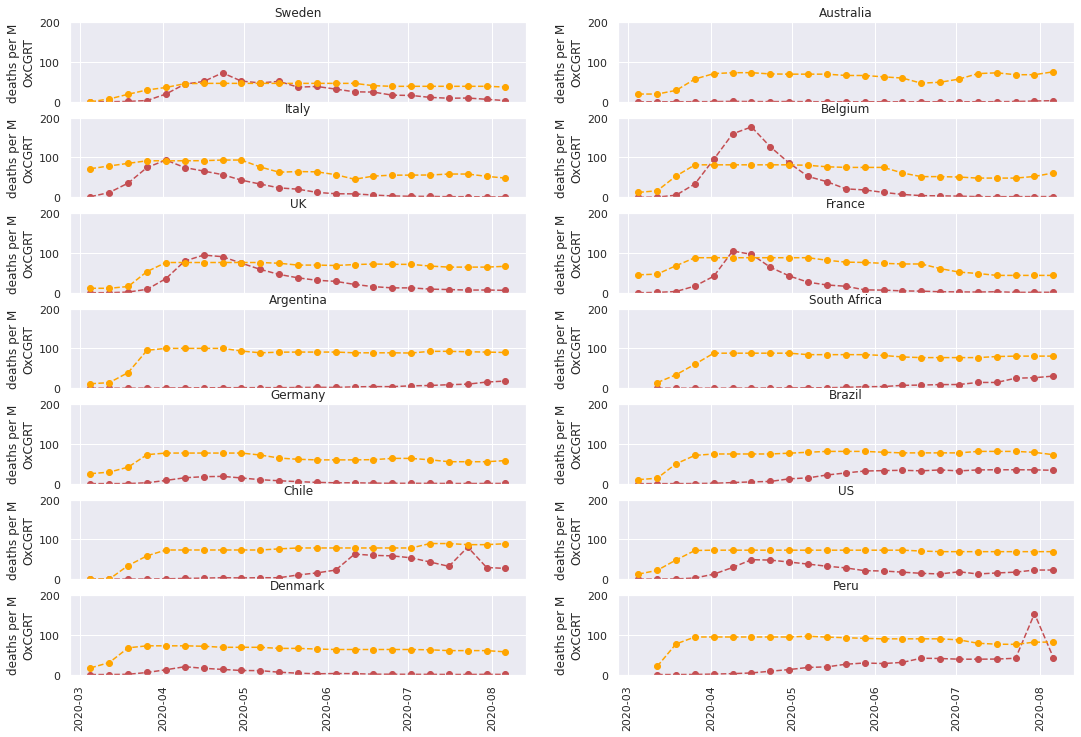

In [572]:
import scipy.stats as sps

weeklies_df = pd.DataFrame()


fig,axes = plt.subplots(7,2,sharex=True,figsize=(18,12))

for i,k in enumerate(weeklies.keys()):
        
    weeklies[k]['country'] = k
        
    weeklies_df = pd.concat([weeklies_df,weeklies[k]])
    
    
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['dead_inc_per_M'],'o--',label='weekly deaths per M',
                           color='r')
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['oxford_stringency_current'],'o--',label='weekly deaths per M',
                           color='orange')
    axes[i % 7,i % 2].tick_params('x',rotation=90)
    axes[i % 7,i % 2].set_title('{}'.format(k))
    axes[i % 7, i % 2].set_ylabel('deaths per M\nOxCGRT')
    axes[i % 7, i % 2].set_ylim([0,200])
    #axes[i % 7, i % 2].set_yscale('log')
    
plt.savefig('oxcgrt_14.jpg',format='jpg',dpi=400)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        1.13   0.29    0.59     1.65       0.01     0.01    560.05   
alpha     -17.55  11.46  -37.62     5.04       0.51     0.37    509.32   
obs_sigma  16.70   3.08   11.66    22.35       0.14     0.10    469.78   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       553.36    562.71    691.35    1.0  
alpha      481.07    503.04    723.52    1.0  
obs_sigma  469.78    373.45    227.82    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        1.70   0.51    0.80     2.68       0.02     0.01    676.34   
alpha     -68.50  33.13 -126.23    -1.78       1.27     0.90    681.10   
obs_sigma  45.92   8.14   32.79    60.98       0.30     0.22    728.38   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       676.34    690.20    635.84    1.0  
alpha      681.10    695.10    643.58    1.0  
obs_sigma  670.99    791.04    691.76    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        0.80   0.29    0.24     1.33       0.01     0.01    672.97   
alpha     -20.21  18.81  -54.80    15.46       0.72     0.59    675.25   
obs_sigma  27.81   4.44   20.13    35.86       0.16     0.12    765.55   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       595.40    668.79    743.22   1.01  
alpha      504.08    666.14    730.09   1.01  
obs_sigma  732.56    811.61    888.22   1.00  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8817512486912195, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        0.09   0.13   -0.17     0.31       0.01     0.00    507.63   
alpha       0.40  10.00  -18.34    19.81       0.44     0.31    512.30   
obs_sigma  10.21   1.94    7.23    13.98       0.11     0.08    315.46   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       507.63    501.26    702.99   1.01  
alpha      512.30    505.59    755.94   1.00  
obs_sigma  315.46    270.80    167.57   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


            mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
beta        0.29  0.07    0.17     0.43       0.00     0.00    640.01  640.01   
alpha     -13.19  4.41  -22.12    -5.35       0.18     0.12    634.40  634.40   
obs_sigma   4.68  0.74    3.41     5.95       0.03     0.02    800.95  800.95   

           ess_bulk  ess_tail  r_hat  
beta         643.14    613.47    1.0  
alpha        638.89    575.21    1.0  
obs_sigma    757.48    616.44    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.9036572861583964, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        0.50   0.17    0.18     0.82       0.01     0.01    453.46   
alpha     -12.05  11.59  -33.29    10.02       0.55     0.39    447.41   
obs_sigma  12.65   2.06    9.16    16.59       0.07     0.05    835.18   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       453.46    462.28    556.13   1.01  
alpha      447.41    455.10    492.79   1.01  
obs_sigma  818.99    863.04    857.20   1.00  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
beta       0.22  0.09    0.05     0.39       0.00     0.00    479.59  479.59   
alpha     -9.05  5.79  -19.94     1.52       0.26     0.19    483.60  483.60   
obs_sigma  5.51  0.95    3.95     7.26       0.05     0.03    400.36  400.36   

           ess_bulk  ess_tail  r_hat  
beta         480.70    538.08    1.0  
alpha        487.79    551.66    1.0  
obs_sigma    355.29    227.49    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
beta       0.02  0.01   -0.00     0.03       0.00     0.00    612.63  555.23   
alpha     -0.52  0.54   -1.43     0.60       0.02     0.02    601.08  497.35   
obs_sigma  0.68  0.11    0.47     0.87       0.00     0.00    519.10  519.10   

           ess_bulk  ess_tail  r_hat  
beta         621.51    579.66    1.0  
alpha        614.82    566.92    1.0  
obs_sigma    454.51    268.12    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8837197525751406, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        1.50   0.21    1.09     1.87       0.01     0.01    358.23   
alpha     -78.92  14.81 -109.16   -53.32       0.80     0.56    345.59   
obs_sigma  15.67   2.63   11.30    20.68       0.10     0.07    732.77   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       358.23    358.26    610.54    1.0  
alpha      345.59    345.35    638.46    1.0  
obs_sigma  732.77    710.91    716.33    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        1.14   0.30    0.56     1.67       0.01     0.01    590.78   
alpha     -56.85  20.82  -95.82   -18.84       0.86     0.61    586.74   
obs_sigma  24.48   4.30   16.56    32.05       0.19     0.14    496.51   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       590.78    592.48    642.08    1.0  
alpha      586.74    590.94    571.71    1.0  
obs_sigma  496.51    434.23    263.76    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
beta       0.05  0.05   -0.04     0.14       0.00     0.00    564.65  423.21   
alpha     -0.18  4.15   -8.44     7.41       0.18     0.16    560.03  337.12   
obs_sigma  5.20  0.93    3.66     6.95       0.04     0.03    669.95  652.89   

           ess_bulk  ess_tail  r_hat  
beta         567.29    611.28    1.0  
alpha        562.54    652.42    1.0  
obs_sigma    656.92    423.22    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6848790402346223, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        0.43   0.14    0.18     0.71       0.01     0.00    552.52   
alpha     -10.52  10.39  -29.23     9.17       0.43     0.31    571.35   
obs_sigma  13.37   2.19    9.95    17.91       0.12     0.09    324.70   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       552.52    550.56    643.86   1.00  
alpha      571.35    569.91    748.93   1.00  
obs_sigma  324.70    297.29    340.93   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        0.47   0.23    0.07     0.94       0.01     0.01    615.80   
alpha     -10.28  16.85  -43.46    20.66       0.68     0.51    615.51   
obs_sigma  24.56   4.21   17.58    32.74       0.16     0.12    671.14   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       615.80    626.26    698.06   1.00  
alpha      552.17    623.72    647.06   1.00  
obs_sigma  655.03    670.02    506.69   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.616778571076103, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta        0.02   0.47   -0.95     0.76       0.04     0.03    118.18   
alpha      26.39  41.06  -38.92   112.00       4.36     3.09     88.68   
obs_sigma  34.32   6.32   24.75    46.82       1.14     0.81     30.65   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       118.18    103.86    345.12   1.04  
alpha       88.68     85.76    391.80   1.04  
obs_sigma   30.65     20.87     18.06   1.11  


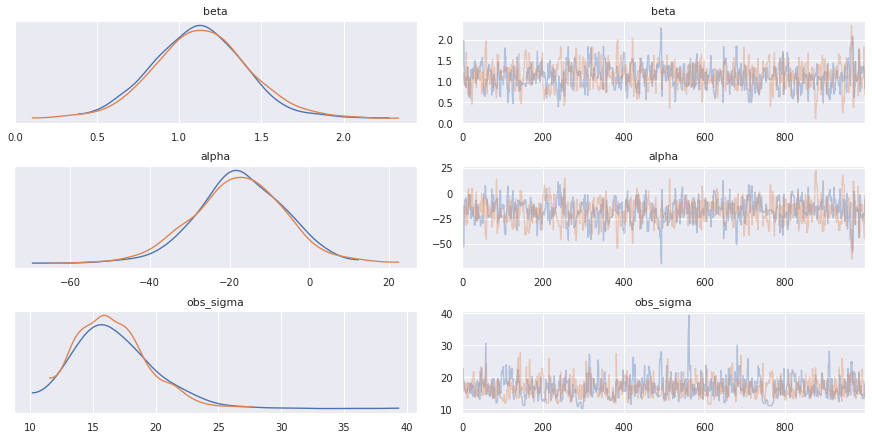

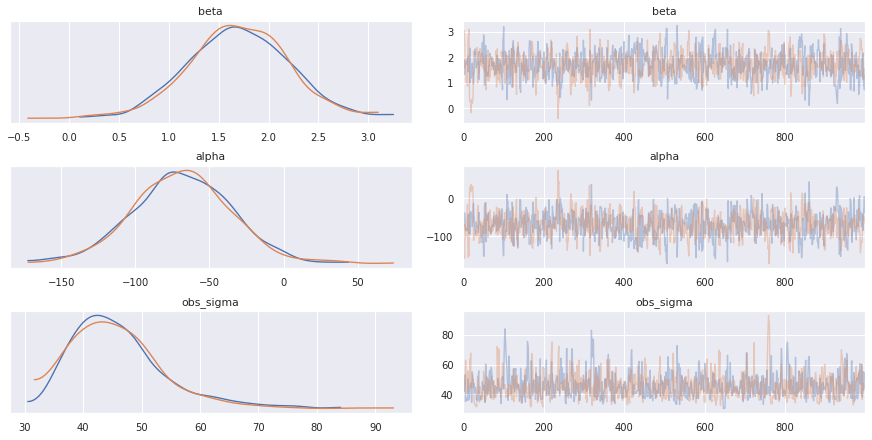

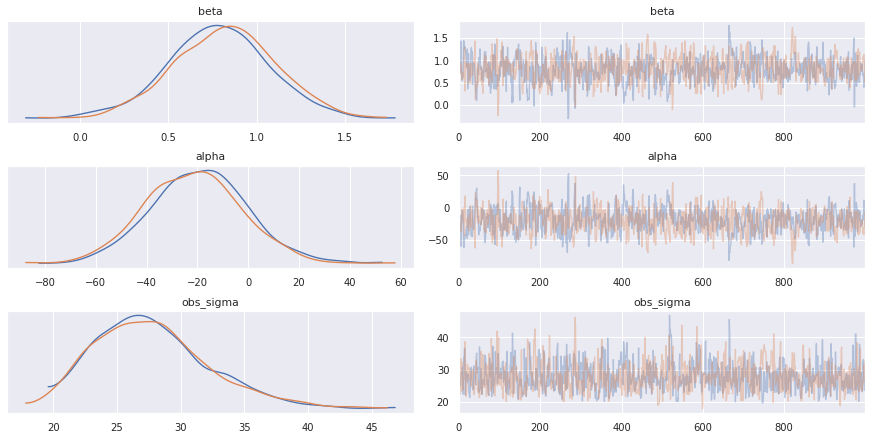

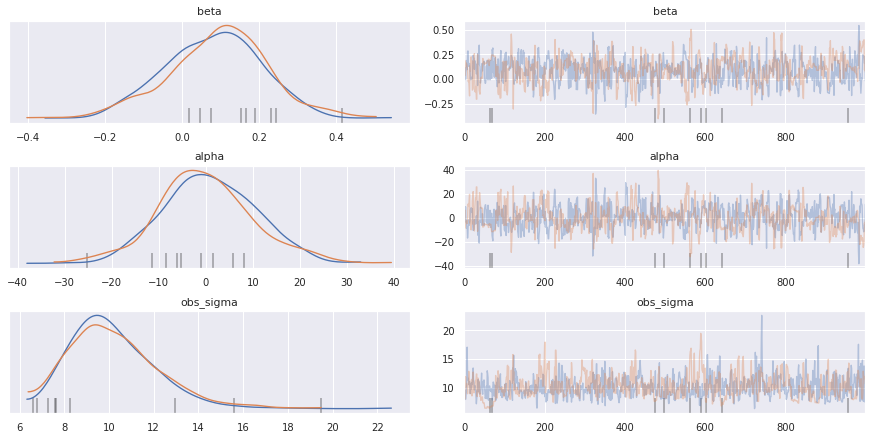

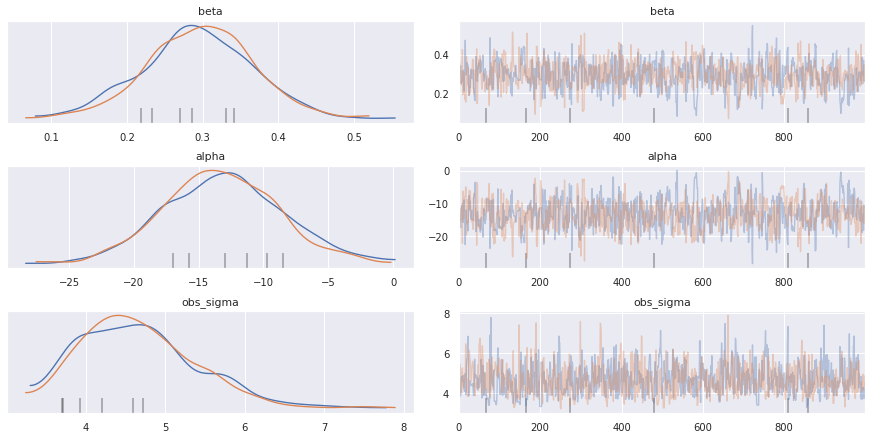

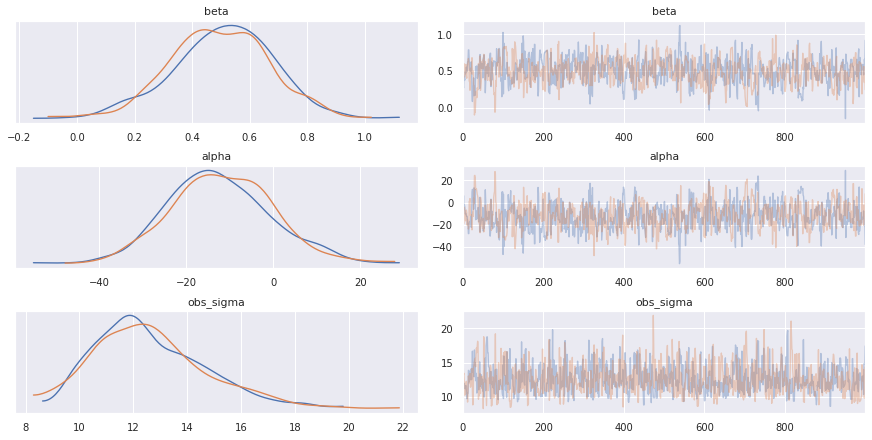

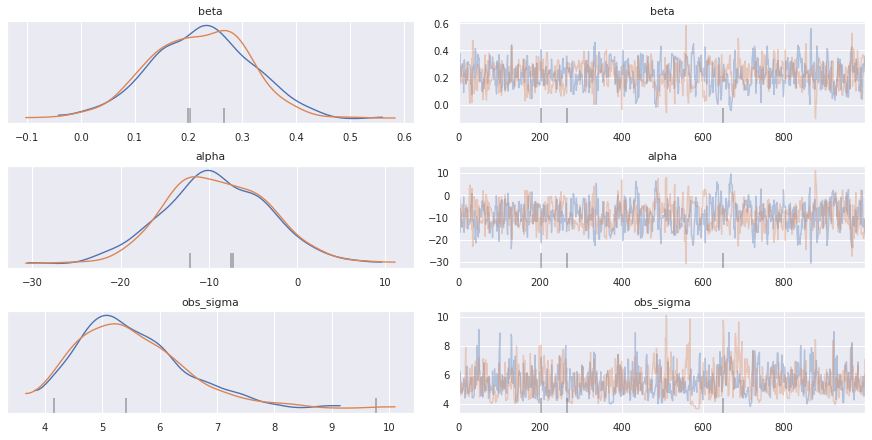

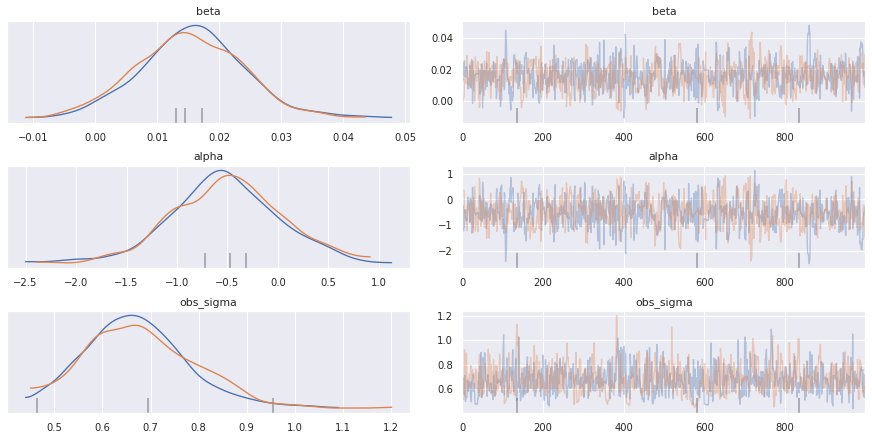

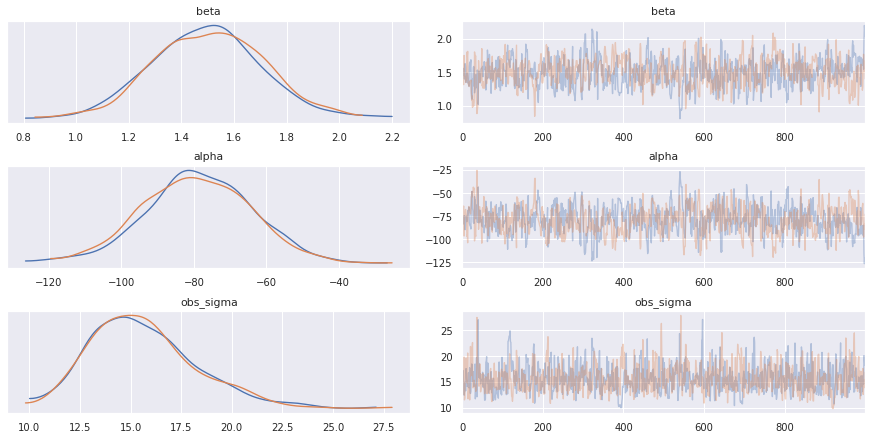

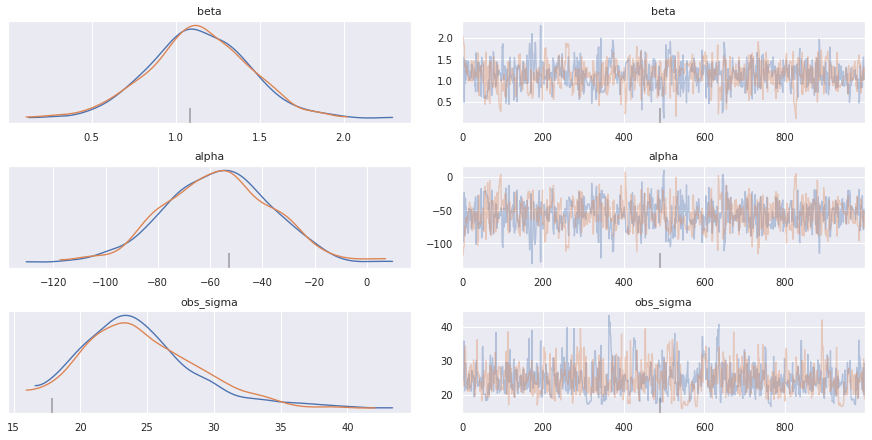

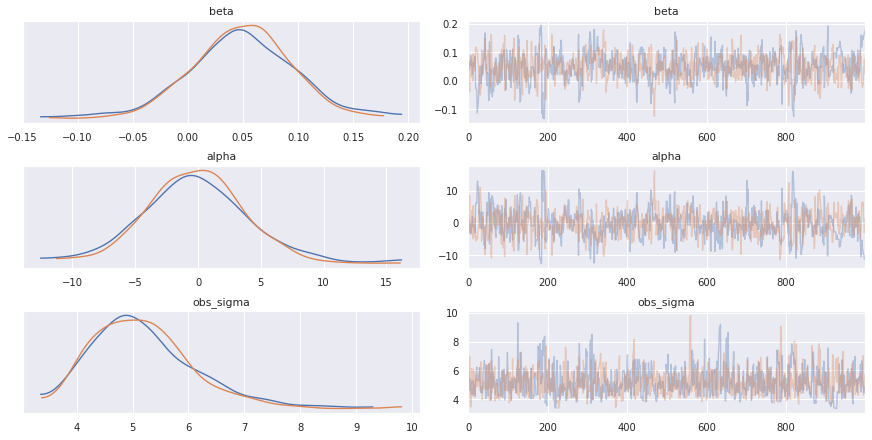

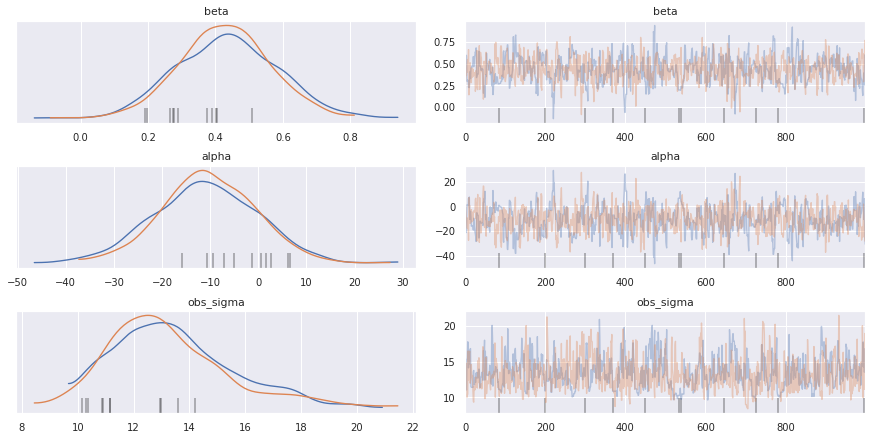

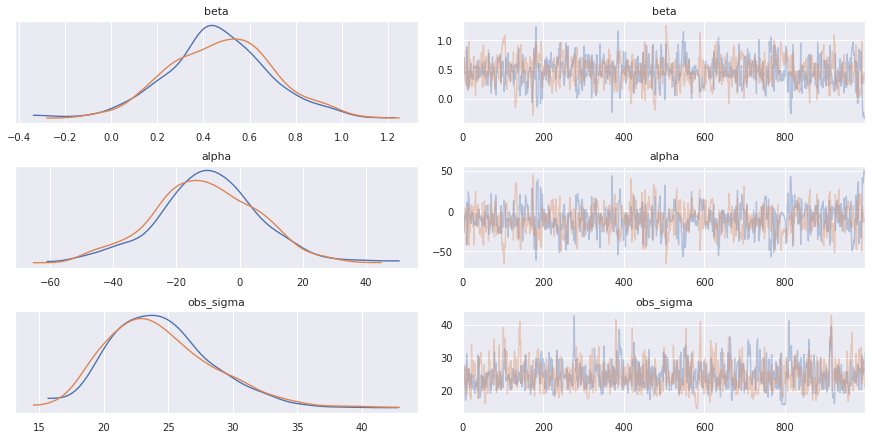

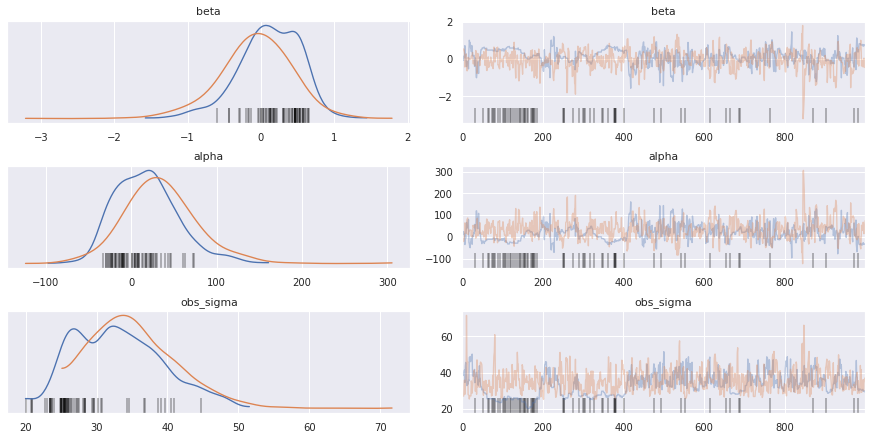

In [573]:
results = dict()

for i,k in enumerate(weeklies.keys()):

    results[k] = inference(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'])



In [574]:


print (results['Argentina'].describe())
results['Sweden'].describe()


         beta_post   alpha_post  obs_sigma_post
count  2000.000000  2000.000000     2000.000000
mean      0.048632    -0.182039        5.196702
std       0.047407     4.147667        0.926244
min      -0.133625   -12.536215        3.355391
25%       0.019407    -2.801405        4.546365
50%       0.049032    -0.223126        5.073395
75%       0.079304     2.289418        5.710413
max       0.194076    16.209917        9.812524


,beta_post,alpha_post,obs_sigma_post
count,2000.000000,2000.000000,2000.000000
mean,1.131208,-17.548247,16.702389
std,0.286284,11.463332,3.078438
min,0.105278,-69.472718,10.151132
25%,0.944705,-24.222302,14.521018
50%,1.122366,-17.440570,16.277187
75%,1.312978,-10.051631,18.377903
max,2.335997,22.455482,39.374666


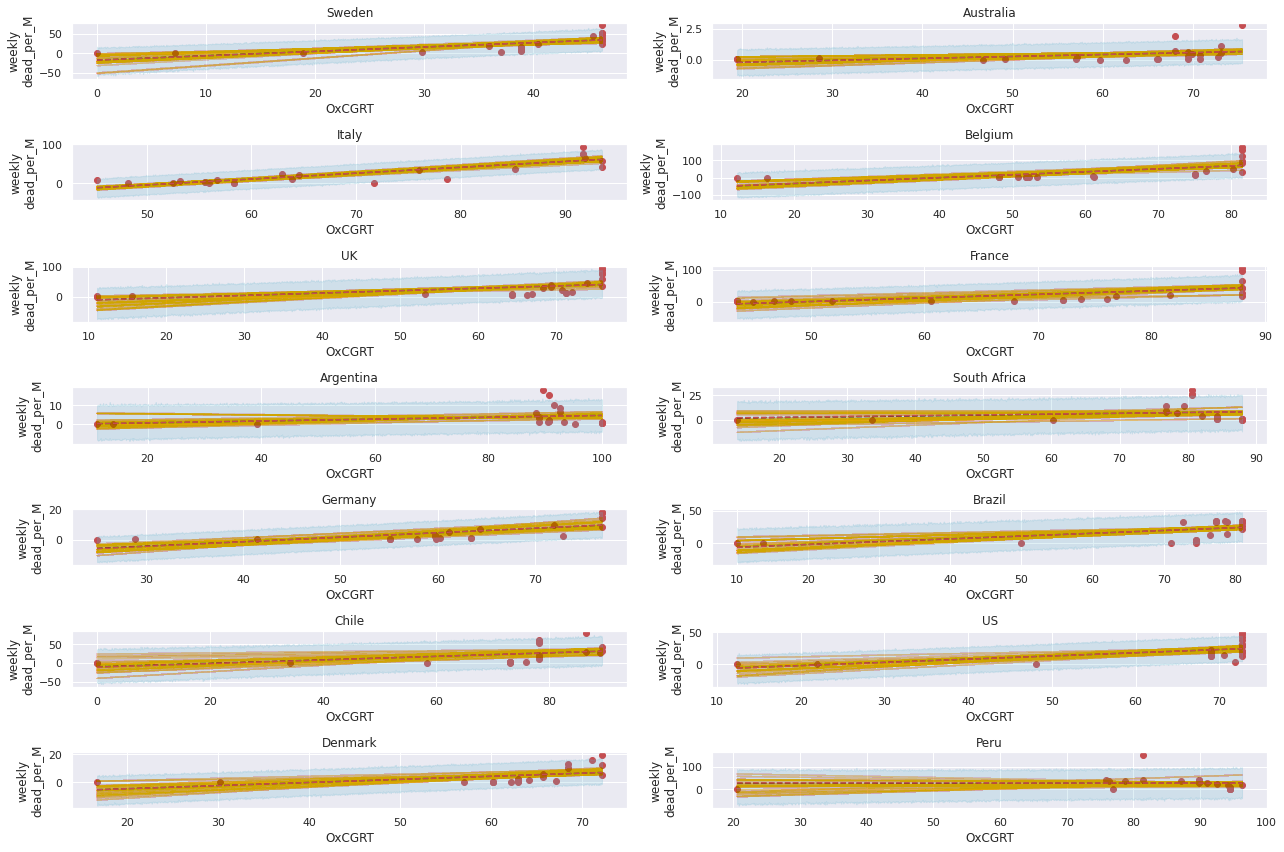

In [575]:
fig,axes = plt.subplots(7,2,figsize=(18,12))

nr_samples = 1000

for i,k in enumerate(weeklies.keys()):

    axes[i % 7,i %2].scatter(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'],color='r')

    slope,intercept,_,_,_ = sps.linregress(weeklies[k]['oxford_stringency_current'],
                                           weeklies[k]['dead_inc_per_M'])

    X = np.linspace(weeklies[k]['oxford_stringency_current'].min(),
                    weeklies[k]['oxford_stringency_current'].max(),nr_samples)
        
    #X = np.linspace(0,100,nr_samples) # for computing samples, this must concur with nr of sample rows
    
    alpha_mean = results[k].alpha_post.mean()
    beta_mean = results[k].beta_post.mean()
    
    axes[i % 7, i %2].plot(X,X*beta_mean + alpha_mean,'--',color='k')
    
    rows = np.random.choice(range(len(weeklies[k].index)),replace=True,size=nr_samples)
    
    lines = [X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post for i in range(len(X))]
    
    samples = np.array([pm.Normal.dist(X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post,
                                      results[k].iloc[rows].obs_sigma_post).random(size=len(X)) for i in range(len(X))])

    high,low = np.percentile(samples,[5.5,94.5],axis=1)
    
    axes[i % 7, i % 2].plot(X,lines,color='orange',alpha=0.01)
    
    least_squares = X * slope + intercept

    axes[i % 7, i % 2].plot(X,least_squares,'--',color='r')
    
    axes[i % 7, i % 2].fill_between(X,high,low,color='c',alpha=0.2)

    
    axes[i % 7, i % 2].set_title(k)
    axes[i % 7, i % 2].set_ylabel('weekly\ndead_per_M')
    axes[i % 7, i % 2].set_xlabel('OxCGRT')
    #axes[i % 7,i % 2].set_ylim([0,150])
    
plt.tight_layout()
plt.savefig('OxCGRT_regression_14.jpg',format='jpg',dpi=400)

In [576]:
swe_weekly = weeklies_df.loc[weeklies_df['country'] == 'Sweden']
bel_weekly = weeklies_df.loc[weeklies_df['country'] == 'Belgium']
arg_weekly = weeklies_df.loc[weeklies_df['country'] == 'Argentina']

In [577]:
swe_weekly

,dead_inc_per_M,dead_per_M,oxford_stringency_current,country
date,,,,
2020-03-05,0.000000,0.000000,0.000000,Sweden
2020-03-12,0.099017,0.099017,7.142857,Sweden
2020-03-19,0.891154,3.069530,18.917143,Sweden
2020-03-26,3.168547,16.832908,29.760000,Sweden
2020-04-02,19.506370,92.580995,35.981429,Sweden
2020-04-09,44.359664,311.309783,45.505714,Sweden
2020-04-16,51.092827,653.908973,46.300000,Sweden
2020-04-23,72.678556,1095.723303,46.300000,Sweden
2020-04-30,51.983981,1549.617720,46.300000,Sweden


<AxesSubplot:xlabel='date'>

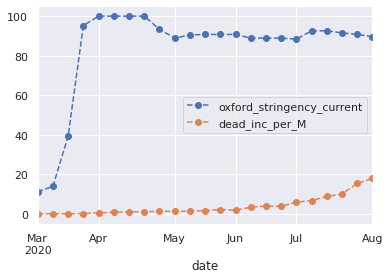

In [578]:

arg_weekly.plot(y=['oxford_stringency_current','dead_inc_per_M'],style='o--')

In [579]:
all_countries = pd.DataFrame()

for c in countries.groups:
    country = countries.get_group(c)
    inc = country['dead'] - country['dead'].shift()
    inc.name='inc'
    country = pd.concat([country,inc],axis=1)
    
    country = country.replace(np.inf,np.nan)
    country = country.dropna()
    all_countries = pd.concat([all_countries,country],axis=0)
    


In [580]:
all_countries.head(50)


,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,inc
160,2020-03-02,1.0,0.0,27.78,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
166,2020-03-08,4.0,0.0,27.78,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
169,2020-03-11,7.0,0.0,27.78,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
173,2020-03-15,10.0,0.0,38.89,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
174,2020-03-16,16.0,0.0,38.89,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
175,2020-03-17,21.0,0.0,38.89,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
176,2020-03-18,22.0,0.0,41.67,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
177,2020-03-19,22.0,0.0,41.67,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
178,2020-03-20,22.0,0.0,41.67,Afghanistan,72.957244,38928346,0.000000,AFG,0.0
179,2020-03-21,24.0,0.0,41.67,Afghanistan,72.957244,38928346,0.000000,AFG,0.0


In [581]:
select_countries = ['Sweden','UK','Spain','Italy','UK','Belgium','France','US','Germany']
select_countries = ['Sweden','UK','Belgium']

mask = all_countries['country'].isin(select_countries)

selected_countries = (all_countries[mask]).copy()
selected_countries

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,inc
1872,2020-03-02,17.0,0.0,11.11,Belgium,62.618931,11589623,0.000000,BEL,0.0
1873,2020-03-03,37.0,0.0,11.11,Belgium,62.618931,11589623,0.000000,BEL,0.0
1874,2020-03-04,72.0,0.0,13.89,Belgium,62.618931,11589623,0.000000,BEL,0.0
1875,2020-03-05,126.0,0.0,13.89,Belgium,62.618931,11589623,0.000000,BEL,0.0
1876,2020-03-06,207.0,0.0,13.89,Belgium,62.618931,11589623,0.000000,BEL,0.0
...,...,...,...,...,...,...,...,...,...,...
9163,2020-08-02,303952.0,46193.0,68.06,UK,63.243333,67886011,680.449467,GBR,74.0
9164,2020-08-03,304695.0,46201.0,68.06,UK,63.243333,67886011,680.567312,GBR,8.0
9165,2020-08-04,305623.0,46210.0,65.28,UK,63.243333,67886011,680.699887,GBR,9.0
9166,2020-08-05,306293.0,46299.0,65.28,UK,63.243333,67886011,682.010908,GBR,89.0


In [582]:
unique_country_abbs = selected_countries['abb'].unique()
print (unique_country_abbs)
country_idx = dict(zip(unique_country_abbs,range(1,len(unique_country_abbs) + 1)))
country_idx    

['BEL' 'SWE' 'GBR']


{'BEL': 1, 'SWE': 2, 'GBR': 3}

In [583]:
unique_days = selected_countries['date'].unique()
day_idx = dict(zip(pd.to_datetime(unique_days),range(1,len(unique_days) + 1)))


In [584]:
def create_country_index(abb):
    return country_idx[abb]

def create_day_index(day):
    return day_idx[day]

selected_countries['country_idx'] = selected_countries['abb'].apply(create_country_index)
selected_countries['day_idx'] = selected_countries['date'].apply(create_day_index)
selected_countries['ox_idx'] = selected_countries['oxford_stringency_current'].astype(int)
selected_countries['inc_per_M'] = selected_countries['inc'] / (selected_countries['pop'] / 1e6)
selected_countries

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,inc,country_idx,day_idx,ox_idx,inc_per_M
1872,2020-03-02,17.0,0.0,11.11,Belgium,62.618931,11589623,0.000000,BEL,0.0,1,1,11,0.000000
1873,2020-03-03,37.0,0.0,11.11,Belgium,62.618931,11589623,0.000000,BEL,0.0,1,2,11,0.000000
1874,2020-03-04,72.0,0.0,13.89,Belgium,62.618931,11589623,0.000000,BEL,0.0,1,3,13,0.000000
1875,2020-03-05,126.0,0.0,13.89,Belgium,62.618931,11589623,0.000000,BEL,0.0,1,4,13,0.000000
1876,2020-03-06,207.0,0.0,13.89,Belgium,62.618931,11589623,0.000000,BEL,0.0,1,5,13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,2020-08-02,303952.0,46193.0,68.06,UK,63.243333,67886011,680.449467,GBR,74.0,3,154,68,1.090063
9164,2020-08-03,304695.0,46201.0,68.06,UK,63.243333,67886011,680.567312,GBR,8.0,3,155,68,0.117845
9165,2020-08-04,305623.0,46210.0,65.28,UK,63.243333,67886011,680.699887,GBR,9.0,3,156,65,0.132575
9166,2020-08-05,306293.0,46299.0,65.28,UK,63.243333,67886011,682.010908,GBR,89.0,3,157,65,1.311021
